In [14]:
# Import modules

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
import time
import optuna
from dask.distributed import Client,  wait

In [15]:
optimization_time_in_seconds = -time.time()

In [16]:
def study_wrapper(study, n_trials):
    # Load and prepare data

    df = pd.read_csv("/app/story/heart_2022_with_nans.csv")

    df.drop_duplicates(inplace=True)

    for col in df.columns:
        if df[col].dtype == 'object':
            min_value = df[col].dropna().mode().iloc[0]
            df[col] = df[col].fillna(min_value)
        else:
            mean_value = df[col].mean()
            df[col] = df[col].fillna(mean_value)

    def bmi_category(bmi):
        if bmi > 24.9:
            return 'Above Normal'
        elif bmi >= 18.5 and bmi <= 24.9:
            return 'Normal'
        else:
            return 'Below Normal'

    # Apply the function to create a new column 'bmi_category'
    df['bmi_category'] = df['BMI'].apply(bmi_category)

    for col in df.select_dtypes(include='object').columns:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])

    correlation_matrix = df.corr()
    strong_correlation_cols = [col for col in correlation_matrix.columns if abs(correlation_matrix.loc['HadHeartAttack', col]) >= 0.06 and col != 'HadHeartAttack']

    # Select features (X) and target (y)
    X = df[strong_correlation_cols]
    y = df['HadHeartAttack']

    s = MinMaxScaler()
    X = s.fit_transform(X)

    # Split data to train and test sets

    x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=12)

    # Defining objective function

    def objective(trial: optuna.Trial):

        n_layers = trial.suggest_int('n_layers', 1, 4)

        per_layer = 100 // n_layers

        layers = [trial.suggest_int(f'n_units_{i}', per_layer, per_layer) for i in range(n_layers)]
        
        for i in range(n_layers, 4):
            trial.suggest_int(f'n_units_{i}', 0, 0)

        activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
        solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
        alpha = trial.suggest_float('alpha', 0.00001, 0.3)
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
        
        clf =  MLPClassifier(hidden_layer_sizes=tuple(layers), activation=activation, solver=solver, alpha=alpha, learning_rate=learning_rate, max_iter=200)
        clf.fit(x_train, y_train)

        y_pred = clf.predict(x_test)
        
        return f1_score(y_test, y_pred)
    
    study.optimize(objective, n_trials=n_trials)


In [17]:
n_workers = 20 # broj worker nodova
n_trials = 50 # broj pokusaja za pronalazenje najboljih parametara

In [18]:
# Split trials to nodes

if n_trials <= n_workers:
    trials_per_node = [1 for i in range(n_trials)]
else:
    whole_trials=n_trials // n_workers
    partional_trials=n_trials % n_workers
    trials_per_node = [whole_trials + (1 if i < partional_trials else 0) for i in range(0, n_workers)]

In [19]:
client = Client("tcp://<server_ip>:<port>")

c:\Users\ljmatovic\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:1617: VersionMismatchWarning: Mismatched versions found

+---------+----------------+-----------------+-----------------+
| Package | Client         | Scheduler       | Workers         |
+---------+----------------+-----------------+-----------------+
| lz4     | None           | 4.3.3           | 4.3.3           |
| python  | 3.10.0.final.0 | 3.10.12.final.0 | 3.10.12.final.0 |
| toolz   | 0.12.1         | 0.12.0          | 0.12.0          |
+---------+----------------+-----------------+-----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


2024-08-12 13:19:38,939 - distributed.batched - INFO - Batched Comm Closed <TCP (closed) Client->Scheduler local=tcp://172.24.126.3:61165 remote=tcp://mn01-fin.bioirc.ac.rs:30100>
Traceback (most recent call last):
  File "c:\Users\ljmatovic\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\batched.py", line 115, in _background_send
    nbytes = yield coro
  File "C:\Users\ljmatovic\AppData\Roaming\Python\Python310\site-packages\tornado\gen.py", line 766, in run
    value = future.result()
  File "c:\Users\ljmatovic\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\comm\tcp.py", line 262, in write
    raise CommClosedError()
distributed.comm.core.CommClosedError


In [20]:
backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.dask.DaskStorage(storage=backend_storage, client=client)
study = optuna.create_study(study_name="MLPClassifier", direction='maximize', storage=dask_storage)

C:\Users\ljmatovic\AppData\Local\Temp\ipykernel_5496\67218996.py:2: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  dask_storage = optuna.integration.dask.DaskStorage(storage=backend_storage, client=client)


In [21]:
futures = []
print(trials_per_node)
start=0
for i in trials_per_node:
    iter_range = (start + 1, start+i)
    start+=i
    futures.append(
        {
            "range": iter_range,
            "futures": [
                client.submit(study_wrapper, study, n_trials=i, pure=False)
            ],
        }
    )
for partition in futures:
    iter_range = partition["range"]
    print(f"Testing hyperparameter combinations {iter_range[0]}..{iter_range[1]}")
    try:
        _ = wait(partition["futures"])
    except:
        print(f"FAILED: Testing hyperparameter combinations {iter_range[0]}..{iter_range[1]}")

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Testing hyperparameter combinations 1..3
Testing hyperparameter combinations 4..6
Testing hyperparameter combinations 7..9
Testing hyperparameter combinations 10..12
Testing hyperparameter combinations 13..15
Testing hyperparameter combinations 16..18
Testing hyperparameter combinations 19..21
Testing hyperparameter combinations 22..24
Testing hyperparameter combinations 25..27
Testing hyperparameter combinations 28..30
Testing hyperparameter combinations 31..32
Testing hyperparameter combinations 33..34
Testing hyperparameter combinations 35..36
Testing hyperparameter combinations 37..38
Testing hyperparameter combinations 39..40
Testing hyperparameter combinations 41..42
Testing hyperparameter combinations 43..44
Testing hyperparameter combinations 45..46
Testing hyperparameter combinations 47..48
Testing hyperparameter combinations 49..50


In [22]:
optimization_time_in_seconds += time.time()

In [23]:
print("Best params:", study.best_params)
print("Best value:", study.best_value)
hours = int(optimization_time_in_seconds) // 3600
minutes = (int(optimization_time_in_seconds) // 60) % 60
seconds = int(optimization_time_in_seconds)
seconds = seconds % 60 + (optimization_time_in_seconds - int(optimization_time_in_seconds))    
print("Optimization time: {} h {} m {} s".format(hours, minutes, seconds))

Best params: {'n_layers': 4, 'n_units_0': 25, 'n_units_1': 25, 'n_units_2': 25, 'n_units_3': 25, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.16499440236231172, 'learning_rate': 'constant'}
Best value: 0.3997997246213544
Optimization time: 0 h 6 m 10.217092990875244 s


In [24]:
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
)

C:\Users\ljmatovic\AppData\Local\Temp\ipykernel_5496\2219974739.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


<Axes: title={'center': 'Heart Disease MLPClassifier Optimization history'}, xlabel='Trial', ylabel='Objective Value'>

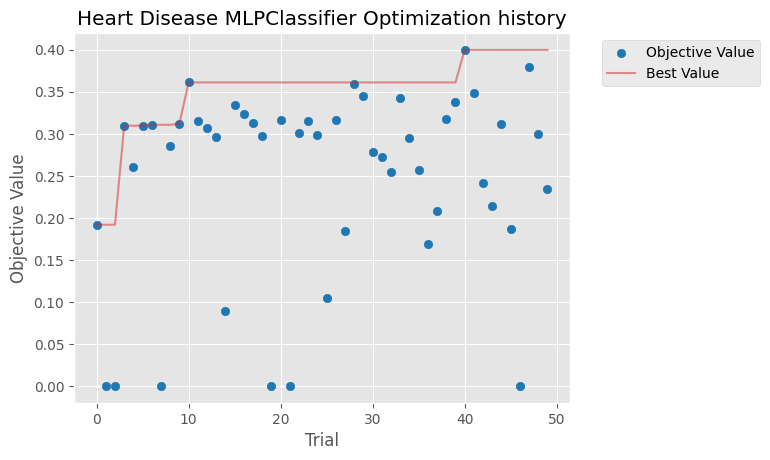

In [25]:
ax = plot_optimization_history(study)
ax.set_title("Heart Disease MLPClassifier Optimization history")
ax

C:\Users\ljmatovic\AppData\Local\Temp\ipykernel_5496\1527310877.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_param_importances(study)


<Axes: title={'left': 'Heart Disease MLPClassifier Hyperparameter Importance'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

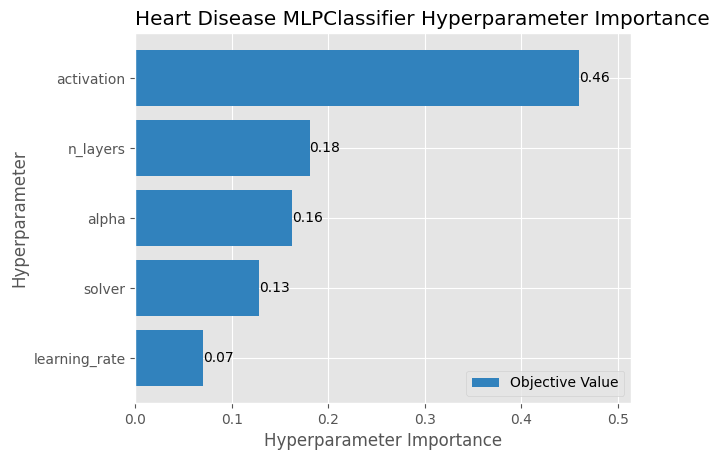

In [26]:
ax = plot_param_importances(study)
ax.set_title("Heart Disease MLPClassifier Hyperparameter Importance", loc="left")
ax